# Cars and tanks trial run

In [1]:
# Preference variables
LAST_TRAIN_MODE=False

In [2]:
import os
import requests

model_file = "yolo11_cnt_last.pt" if LAST_TRAIN_MODE else "yolo11_cnt_best.pt"

if not os.path.exists(model_file):
    dl_link = {
        "yolo11_cnt_best.pt": "https://drive.google.com/uc?export=download&id=1zfCXSVrKpa38N9EauT-Z18xXgFPl6kuI",
        "yolo11_cnt_last.pt": "https://drive.google.com/uc?export=download&id=1_gkYs4yPl8kTgON-uJBKfsX3bAP5cf42"
    }

    with requests.get(dl_link[model_file], stream=True) as response:
        response.raise_for_status()
        with open(model_file, "wb") as f:
            for c in response.iter_content(chunk_size=1024 * 256):
                f.write(c)
        print("Pretrained file has been downloaded successfully.")


This notebook evaluates accuracy from external source images as well as annotate the object

In [3]:
from ultralytics import YOLO
import cv2

from pathlib import Path

img_data_dir = Path("data/images/")
imgs = [str(candidate)
        for ext_pattern in (
            '*.jpg',
            '*.png',
            '*.jpeg'
        )
        for candidate in img_data_dir.glob(ext_pattern)]

if not imgs:
    raise FileNotFoundError("Detection aborted due to no images with eligible extensions (JPG or PNG format) found.")

model = YOLO(model_file)

results = model.predict(imgs, conf=0.7, imgsz=256)

out_dir = Path("data/cnt_result/")

for idx, r in enumerate(results):
    origin_name = Path(imgs[idx]).stem
    export_path = out_dir / f"{origin_name}_predict.jpg"
    cv2.imwrite(str(export_path.absolute()), r.plot())


0: 256x256 car 1.00, tank 0.00, 7.9ms
1: 256x256 car 1.00, tank 0.00, 7.9ms
2: 256x256 car 1.00, tank 0.00, 7.9ms
3: 256x256 car 1.00, tank 0.00, 7.9ms
4: 256x256 car 1.00, tank 0.00, 7.9ms
5: 256x256 car 1.00, tank 0.00, 7.9ms
6: 256x256 car 1.00, tank 0.00, 7.9ms
7: 256x256 car 1.00, tank 0.00, 7.9ms
8: 256x256 car 1.00, tank 0.00, 7.9ms
9: 256x256 car 1.00, tank 0.00, 7.9ms
10: 256x256 car 1.00, tank 0.00, 7.9ms
11: 256x256 car 1.00, tank 0.00, 7.9ms
12: 256x256 car 1.00, tank 0.00, 7.9ms
13: 256x256 car 1.00, tank 0.00, 7.9ms
14: 256x256 car 1.00, tank 0.00, 7.9ms
15: 256x256 car 1.00, tank 0.00, 7.9ms
16: 256x256 car 1.00, tank 0.00, 7.9ms
17: 256x256 car 1.00, tank 0.00, 7.9ms
18: 256x256 car 1.00, tank 0.00, 7.9ms
19: 256x256 car 1.00, tank 0.00, 7.9ms
20: 256x256 car 1.00, tank 0.00, 7.9ms
21: 256x256 car 1.00, tank 0.00, 7.9ms
22: 256x256 car 1.00, tank 0.00, 7.9ms
23: 256x256 car 1.00, tank 0.00, 7.9ms
24: 256x256 car 0.88, tank 0.12, 7.9ms
25: 256x256 car 1.00, tank 0.00, 7

In [4]:
import pandas as pd
import numpy as np

data = {
    'Probability means': [
        np.mean([float(r.probs.data[0]) for r in results[0:99]] # Car
                + [float(r.probs.data[1]) for r in results[100:200]]), # Tank
        np.mean([float(r.probs.data[1]) for r in results[0:99]] # Car (false detect as tank)
                + [float(r.probs.data[0]) for r in results[100:200]]), # Tank (false detect as car)
    ]
}

print("Probability mean of classification accuracy")
pd.DataFrame(data, index=["True", "False"])

Probability mean of classification accuracy


,Probability means
True,0.981571
False,0.018429


In [5]:
conf_matrix = {
    "car": {
        "car": sum(r.probs.top1 == 0 for r in results[0:99]),
        "tank": sum(r.probs.top1 == 1 for r in results[0:99]),
    }, "tank": {
        "car": sum(r.probs.top1 == 0 for r in results[100:200]),
        "tank": sum(r.probs.top1 == 1 for r in results[100:200]),
    }
}

print("Confusion matrix")
pd.DataFrame(conf_matrix, index=["car", "tank"])

Confusion matrix


,car,tank
car,98,2
tank,1,98


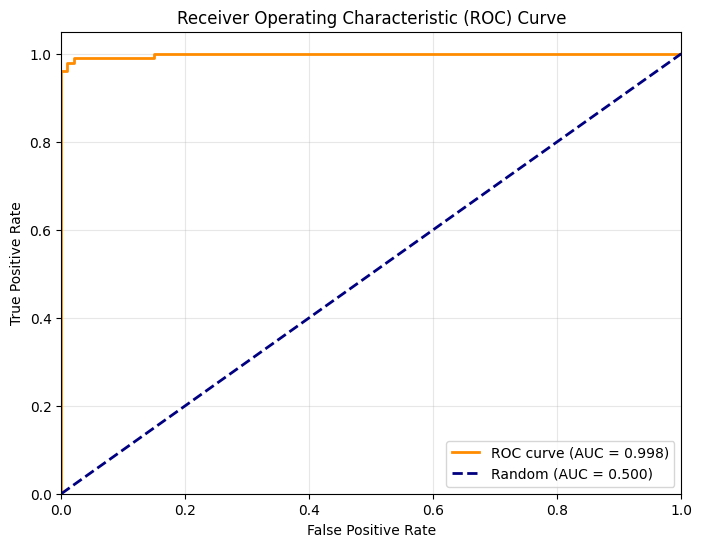

AUC Score: 0.998

Sample thresholds:


,Threshold,FPR,TPR
0,inf,0.00,0.00
1,1.000000e+00,0.00,0.81
2,9.999999e-01,0.00,0.82
3,9.999998e-01,0.00,0.84
4,9.976742e-01,0.00,0.96
5,9.899221e-01,0.01,0.96
6,9.574492e-01,0.01,0.98
7,9.336112e-01,0.02,0.98
8,8.786014e-01,0.02,0.99
9,7.956084e-03,0.15,0.99


In [9]:
    from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prepare true labels and prediction scores
true_labels = []
pred_scores = []  # Scores for the positive class (tank)

# Assuming first 100 images are cars (class 0) and next 100 are tanks (class 1)
for idx, r in enumerate(results):
    # Get true label based on your dataset organization
    if idx < 100:  # First 100 are cars
        true_labels.append(0)  # Car = class 0
    else:  # Next 100 are tanks
        true_labels.append(1)  # Tank = class 1
    
    # Get probability for car class (class 0)
    # r.probs.data[0] = car probability, r.probs.data[1] = tank probability
    #print(float(r.probs.data[0]))
    car_prob = float(r.probs.data[0])  # Probability for car class
    pred_scores.append(car_prob)

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_scores = np.array(pred_scores)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, pred_scores, pos_label=0)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Print AUC value
print(f"AUC Score: {roc_auc:.3f}")

# Optional: Display some thresholds
print("\nSample thresholds:")
pd.DataFrame({
    "Threshold": [thresholds[i] for i in range(0, len(thresholds), max(1, len(thresholds)//10))],
    "FPR": [fpr[i] for i in range(0, len(thresholds), max(1, len(thresholds)//10))],
    "TPR": [tpr[i] for i in range(0, len(thresholds), max(1, len(thresholds)//10))],
})